In [1]:
from netCDF4 import Dataset
import numpy as np

In [2]:
filename='Slab2Distribute_Mar2018/ryu_slab2_dep_02.26.18.grd'
nc_fid=Dataset(filename,'r')
#nc_fid.variables

In [3]:
x = nc_fid.variables['x'][:]
y = nc_fid.variables['y'][:]
z = nc_fid.variables["z"][:]

In [4]:
nx = x.shape[0]
ny = y.shape[0]

In [5]:
mask = z.mask

x, y = np.meshgrid(x, y)
x = x[mask == False]
y = y[mask == False]
z = z[mask == False]

In [6]:
import matplotlib.pylab as plt

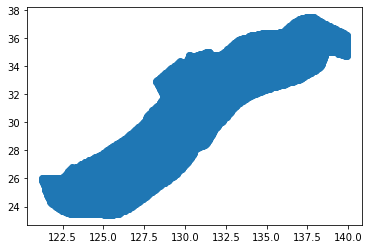

In [7]:
plt.scatter(x.flatten(), y.flatten())

In [8]:
x.shape

(33661,)

In [9]:
from scipy.interpolate import griddata

xi = np.linspace(x.min(),x.max(),nx)
yi = np.linspace(y.min(),y.max(),ny)
# grid the data.
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='nearest')

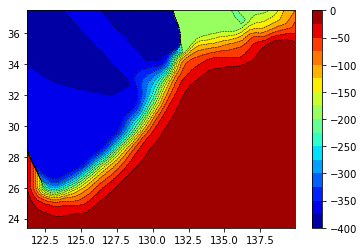

In [10]:
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
plt.show()

In [11]:
from skimage.filters import gaussian

for i in range(4):
    zi = gaussian(zi, sigma=5, preserve_range=True)

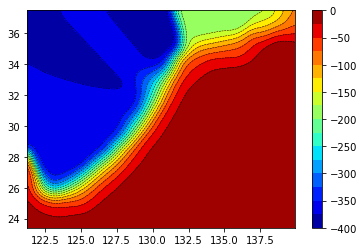

In [12]:
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
plt.show()

## Extract the contour of the slab

In [13]:
values = np.where(mask, 0, 1)

In [14]:
values = gaussian(values, 3, preserve_range=True)

In [15]:
values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
from skimage import measure

In [17]:
around = measure.find_contours(values, 0.5)

In [18]:
around

[array([[370.15019549, 436.        ],
        [370.30086689, 435.        ],
        [370.38607449, 434.        ],
        ...,
        [369.91517428, 437.        ],
        [370.        , 436.64614223],
        [370.15019549, 436.        ]])]

In [19]:
x = around[0][:,0]
y = around[0][:,1]
i = np.floor(x).astype("int")
j = np.floor(y).astype("int") 

In [20]:
import gmsh
gmsh.initialize()
gmsh.model.add("test")

In [21]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 2)

In [22]:
pts_list = []
for idx in range(len(x)):
        pt = gmsh.model.geo.add_point(x[idx], y[idx], 0)
        pts_list.append(pt)
        
if pts_list:
    pts_list = pts_list + [pts_list[0]]
    line_list = []
    for idx in range(len(pts_list)-1):
        pt1 = pts_list[idx]
        pt2 = pts_list[idx+1]
        line_list.append(gmsh.model.geo.add_line(pt1, pt2))

In [23]:
cl = gmsh.model.geo.add_curve_loop(line_list)
gmsh.model.geo.add_plane_surface([cl])

1

In [24]:
gmsh.model.geo.synchronize()

In [25]:
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 16 (Line)
Info    : [ 10%] Meshing curve 17 (Line)
Info    : [ 10%] Meshing curve 18 (Line)
Info    : [ 10%] Meshing curve 19 (Line)
Info    : [ 10%] Meshing curve 20 (Line)
Info    : [ 10%] Meshing curve 21 (Line)
Info    : [ 10%] Meshing curve 22 (Line)
Info    : [ 10%] Meshing curve 23 (Line)
Info    : [ 10%] Meshing curve 24 (Line)
I

Info    : Done meshing 2D (Wall 6.67548s, CPU 6.59841s)
Info    : 105726 nodes 212795 elements


In [26]:
nodeTags = {}
nodeCoords = {}
elementTypes = {}
elementTags = {}
elementNodeTags = {}

In [27]:
entities = gmsh.model.get_entities()

In [28]:
# get the nodes and elements
for e in entities:
    nodeTags[e], nodeCoords[e], _ = gmsh.model.mesh.getNodes(e[0], e[1])
    elementTypes[e], elementTags[e], elementNodeTags[e] = gmsh.model.mesh.getElements(e[0], e[1])

In [29]:
gmsh.model.mesh.clear()

In [30]:
import numpy as np
import random
import math

for e in entities: 
    for i in range(2, len(nodeCoords[e]), 3):
        ii = int(math.floor(nodeCoords[e][i-2]))
        jj = int(math.floor(nodeCoords[e][i-1]))
        nodeCoords[e][i] = zi[ii, jj]
    gmsh.model.mesh.addNodes(e[0], e[1], nodeTags[e], nodeCoords[e])
    gmsh.model.mesh.addElements(e[0], e[1], elementTypes[e], elementTags[e],
                               elementNodeTags[e])

In [31]:
gmsh.write("test.vtk")

Info    : Writing 'test.vtk'...
Info    : Done writing 'test.vtk'


In [32]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.10.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20220501
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.1
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------
